In [21]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import re
import os
import plotly.graph_objects as go
import gzip
from IPython.display import Image

In [22]:
pd.set_option("display.max_columns", 100)

# Load data sets

## NCH array results (queries)

In [23]:
df = pd.read_csv("cnv_data/NCH-microarray-CNVs-cleaned.csv")
df = df[
    df["start_38"].notna() & df["stop_38"].notna()
].copy()  ### restrict to variants with valid GRCh38 start and stop positions
df.head()

variant   build chromosome      start  \
0          7q35(146581450_146661741)x3  GRCh37          7  146581450   
1  22q11.21q11.23(21798705_23751189)x3  GRCh37         22   21798705   
2            18p11.32(146484_408044)x1  GRCh37         18     146484   
3        3q25.1(150353937_150944378)x1  GRCh37          3  150353937   
4         16p12.1(27864452_27995317)x3  GRCh37         16   27864452   

        stop   start_38    stop_38 copy_number  copy_number_min  \
0  146661741  146884357  146964649           3                3   
1   23751189   21444415   23409002           3                3   
2     408044     146483     408044           1                1   
3  150944378  150636149  151226590           1                1   
4   27995317   27853130   27983996           3                3   

   copy_number_max  
0                3  
1                3  
2                1  
3                1  
4                3

In [24]:
len(df)

8685

## ClinVar CNVs (search space)

In [25]:
dv = pd.read_csv("cnv_data/ClinVar-CNVs-normalized.csv")

In [26]:
dv.head()

id                                               name  \
0  1676567           NM_005445.4(SMC3):c.1343dup (p.Glu449fs)   
1    29615  NC_000014.9:g.(53815591_53825260)_(53983697_53...   
2   616733        GRCh37/hg19 Xp22.31(chrX:8595820-8676423)x3   
3  1340674  GRCh37/hg19 7q31.33-32.1(chr7:127050634-127826...   
4  1340493     GRCh37/hg19 12p12.3(chr12:17595624-18236175)x3   

     variation_type assembly  chr   start_38    stop_38  absolute_copies  \
0       Duplication      NaN  NaN  110589641  110589642              NaN   
1          Deletion      NaN  NaN   53825259   53983698              NaN   
2  copy number gain   GRCh37    X    8627778    8708382              3.0   
3  copy number gain   GRCh37    7  127410579  128186178              3.0   
4  copy number gain   GRCh37   12   17442689   18083241              3.0   

   min_copies  max_copies  
0         NaN         NaN  
1         NaN         NaN  
2         NaN         NaN  
3         NaN         NaN  
4         NaN         NaN

In [27]:
len(dv)

79330

## MANE transcript data
Locations of genomic features (genes, coding sequences) for feature-restricted variant overlap

(From ```https://ftp.ncbi.nlm.nih.gov/refseq/MANE/MANE_human/current/```)

In [28]:
gz_file = "cnv_data/MANE.GRCh38.v1.1.ensembl_genomic.gff.gz"
with gzip.open(gz_file, "rb") as f:
    dg = pd.read_csv(f, sep="\t", header=None, skiprows=9)

dg.columns = ["chromosome", "source", "type", "start", "stop", "_0", "_1", "_2", "info"]
dg = dg[
    [c for c in dg.columns if not c.startswith("_")]
]  ## restrict only to necessary columns

In [29]:
## restrict only to features of interest for CNV overlap analysis: genes and coding exons
dg = dg[dg["type"].isin(["gene", "CDS"])].copy()

In [30]:
## get the gene name from the info field
dg["info_gene"] = dg["info"].apply(lambda info: re.findall("name=([^;]+)", info)[0])

In [31]:
## get chromosome names without prefix and without suffix for alternate transcripts
dg["chrom_normalized"] = dg["chromosome"].apply(lambda x: x.strip("chr").split("_")[0])

In [32]:
dg["start"] = dg["start"].astype(int)
dg["stop"] = dg["stop"].astype(int)

In [33]:
dg = dg[
    ["type", "source", "chromosome", "chrom_normalized", "start", "stop", "info_gene"]
]

In [34]:
dg

type          source            chromosome chrom_normalized    start  \
1       CDS  ensembl_havana                  chr1                1  3244087   
3       CDS  ensembl_havana                  chr1                1  3385152   
5       CDS  ensembl_havana                  chr1                1  3396491   
7       CDS  ensembl_havana                  chr1                1  3402791   
9       CDS  ensembl_havana                  chr1                1  3404739   
...     ...             ...                   ...              ...      ...   
521706  CDS          havana  chr19_KI270916v1_alt               19    29602   
521708  CDS          havana  chr19_KI270916v1_alt               19    26397   
521710  CDS          havana  chr19_KI270916v1_alt               19    22029   
521712  CDS          havana  chr19_KI270916v1_alt               19    21514   
521714  CDS          havana  chr19_KI270916v1_alt               19    21374   

           stop info_gene  
1       3244137    PRDM16  
3       3385286    PRDM16  
5       3396593    PRDM16  
7       3402998    PRDM16  
9       3404886    PRDM16  
...         ...       ...  
521706    29895   KIR2DS1  
521708    26447   KIR2DS1  
521710    22133   KIR2DS1  
521712    21566   KIR2DS1  
521714    21415   KIR2DS1  

[212261 rows x 7 columns]

# Auxilliary functions for matching base pair ranges

In [35]:
def intersect_range_with_range(range1: tuple, range2: tuple) -> tuple:
    """returns the interval of intersection between two input intervals
    range1=(start1,stop1) and range2=(start2,stop2) are tuples
    """
    a1, b1 = range1
    a2, b2 = range2
    if any(pd.isna([a1, a2, b1, b2])):
        return None
    a = max([a1, a2])
    b = min([b1, b2])
    return (a, b) if a <= b else None


def intersect_range_with_multiple_ranges(range1: tuple, list_of_ranges: list) -> list:
    """returns the interval(s) of intersection between range1=(start,stop)
    and list_of_ranges=[(start_1,stop_1), ..., (start_n, stop_n)]"""
    res = []
    for rng in list_of_ranges:
        rng_intersect = intersect_range_with_range(range1, rng)
        if rng_intersect is None:
            pass
        else:
            res.append(rng_intersect)
    return res

## Measuring CNV intersections and feature-restricted intersections
We will measure overlap between two CNVs in two ways: (1) total base pair overlap (2) base pair overlap restricted to a genomic feature (e.g. coding sequence)

For (1): If $\text{CNV}_1$ spans the interval $(a,b)$ and $\text{CNV}_2$ spans the interval $(c,d)$, then they overlap on the intersection of these intervals, that is: $\text{overlap}(\text{CNV}_1,\text{CNV}_2) = (a,b)\cap (c,d)$. Furthermore, in this case it is easy to compute this intersection as $(a,b) \cap (c,d) = (\max(a,c), \min(b,d))$

For (2): If $\text{CNV}_1$ overlaps coding sequences on the intervals $(a_1,b_1), ..., (a_m,b_m)$ and $\text{CNV}_2$ overlaps coding sequences on the intervals $(c_1,d_1), ... ,(c_n, d_n)$, then their coding sequence-restricted overlap is on the intersection of the unions of these intervals, that is:

$$\text{overlap}_\text{coding}(\text{CNV}_1, \text{CNV}_2) = [(a_1, b_1) \cup \cdots \cup (a_m, b_m)] \cap [(c_1, d_1) \cup \cdots (c_n, d_n)]$$

Calculating this intersection by brute force entails finding the intersection of each $(a_i, b_i)$ with each $(c_j, d_j)$ <i> and </i> accounting for redundancy becomes computationally cumbersome. The functions below implement a procedure for calculating this intersection more efficiently. In essence, the algorithm implemented consists of the following steps:
* We line up all the starts and stops from both collections of intervals in numerical order
* We follow the number line from left to right, tracking whether our current location belongs to either $\text{CNV}_1$ or $\text{CNV}_2$'s coding overlap sets. 
* The stretches for which our current location belongs to both coding overlap sets are appended to the result; after we have scrolled over all of the start and stop points, we will have found the entire intersection set

In [36]:
### the first function weaves the two interval ranges together so the start and stop positions can be read in numerical order, tracking which intervals begin and end overlap regions for each variant
def interlaced_tagged_ranges(ranges1: list, ranges2: list) -> list:
    """returns tuples corresponding to all endpoint values that occur in poth sets of input ranges
    components of each tuple: (endpoint_value, is_stop, input_num)"""
    if not isinstance(ranges1, list):
        ranges1 = []
    if not isinstance(ranges2, list):
        ranges2 = []

    rngs1_tag = (
        [(rng[0], 0, 0) for rng in ranges1] + [(rng[-1], 1, 0) for rng in ranges1]
    )  ### each tuple has the form (position, is_stop, input_num). consequently, they are sorted by (1) numerical value (2) whether they start/stop the interval then (3) which input CNV they came from
    rngs2_tag = [(rng[0], 0, 1) for rng in ranges2] + [
        (rng[-1], 1, 1) for rng in ranges2
    ]
    return sorted(rngs1_tag + rngs2_tag)


### the second function calculates the intersection of the two
def feature_overlap_intersection(ranges1: list, ranges2: list) -> list:
    endpoints_tagged = interlaced_tagged_ranges(ranges1, ranges2)
    res = []
    state, prev_state = 0, 0
    state1, state2 = 0, 0
    a, b = None, None
    for val, end, inp in endpoints_tagged:
        state1 = state1 + (1 - inp)
        state2 = state2 + inp
        prev_state = state
        state = (state1 * state2) % 2
        if state - prev_state == 1:
            a = val
        elif state - prev_state == -1:
            b = val
            res.append((a, b))
    return res


### this removes any redundancies in the representation produced by "feature_overlap_intersection"
### also corrects intervals of the form: (a,b) \union (b,c)
def union_list_of_ranges(ranges: list) -> list:
    res_ranges = []
    open_prev, open_current = 0, 0
    a, b = None, None
    endpts_interlace = sorted(
        [(rng[0], -1) for rng in ranges] + [(rng[-1], 1) for rng in ranges]
    )
    for pos, incr in endpts_interlace:
        open_prev = open_current
        open_current = (
            open_current - incr
        )  ### "-" used because "-1" indicates the start of an interval in "endpts_interlace"; for sorting reasons, want starts to appear before stops
        if (open_prev, open_current) == (0, 1):
            a = pos
        elif (open_prev, open_current) == (1, 0):
            b = pos
            res_ranges.append((a, b))
    return res_ranges

In [37]:
def get_sizes_of_ranges(ranges: list) -> int:
    """calculates the size of the union of the input list of intervals"""
    if not isinstance(ranges, list) or ranges == []:
        return 0
    return sum([b - a + 1 for a, b in ranges])


## needed for enforcing correct types in later dataframes; pass back and forth between string and list representations of overlap sets
def get_string_from_ranges(ranges: list) -> str:
    """converts list to a ";"-separated string of"""
    return ";".join([",".join(map(str, list(rng))) for rng in ranges])


def get_ranges_from_string(ranges_string: str) -> list:
    """converts ";"-separated string to a list of tuples of (start,stop) positions of intervals"""
    if ranges_string == "":
        return []
    return [tuple(map(float, rng.split(","))) for rng in ranges_string.split(";")]

In [38]:
### given a query dataframe and a dataframe consisting of elements to find overlap with, returns a map of query variants --> overlap regions
def build_query_to_ranges_map(
    query_data: pd.core.frame.DataFrame,
    query_chrom_key: str,
    query_start_key: str,
    query_stop_key: str,
    query_key: str,
    search_data: pd.core.frame.DataFrame,
    search_chrom_key: str,
    search_start_key: str,
    search_stop_key: str,
) -> dict:
    result_map = dict()
    dq = query_data.copy()
    ds = search_data.copy()
    for chrom in tqdm(dq[query_chrom_key].unique()):
        dq_ = dq[dq[query_chrom_key] == chrom].copy()
        ds_ = ds[ds[search_chrom_key] == chrom].copy()
        # for ix,rec in tqdm(dq_.iterrows(), desc=f"Chr{chrom}", total = len(dq_)):
        for ix, rec in dq_.iterrows():
            q_var = rec[query_key]
            q_start = rec[query_start_key]
            q_stop = rec[query_stop_key]

            ds_match = ds_[
                (ds_[search_start_key] <= q_stop) & (ds_[search_stop_key] >= q_start)
            ].copy()
            s_ranges = list(zip(ds_match[search_start_key], ds_match[search_stop_key]))
            result_map[q_var] = intersect_range_with_multiple_ranges(
                (q_start, q_stop), s_ranges
            )
    return result_map

# Find NCH (query variant) intersection ranges with genes and coding exons

In [39]:
### finds gene and coding sequence overlap for NCH variants
### runs in approximately ~30s

for element in ["gene", "CDS"]:
    df[f"{element}_intersection_ranges"] = df["variant"].map(
        build_query_to_ranges_map(
            query_data=df,
            query_chrom_key="chromosome",
            query_start_key="start_38",
            query_stop_key="stop_38",
            query_key="variant",
            search_data=dg[dg["type"] == element],
            search_chrom_key="chrom_normalized",
            search_start_key="start",
            search_stop_key="stop",
        )
    )
    ### avoid listing duplicate overlap ranges in the same span
    df[f"{element}_intersection_ranges"] = df[f"{element}_intersection_ranges"].apply(
        union_list_of_ranges
    )

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

In [40]:
### finds fraction of coding sequence overlap regions relative to gene overlap regions for each variant

for element in ["gene", "CDS"]:
    df[f"{element}_overlap"] = df[f"{element}_intersection_ranges"].apply(
        get_sizes_of_ranges
    ) / (df["stop_38"] - df["start_38"] + 1)
df["CDS_overlap_of_gene"] = df["CDS_overlap"] / df["gene_overlap"]

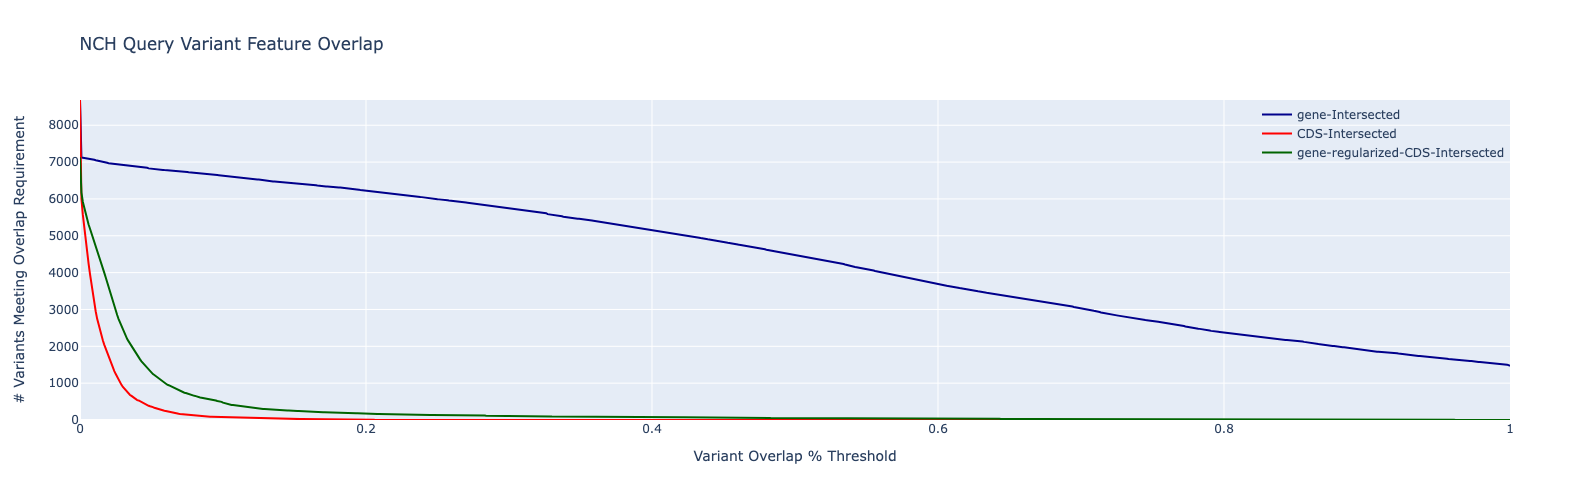

In [41]:
fig = go.Figure()

thrs = list(np.arange(0, 1.001, 0.001))
values_dict = {"gene": [], "CDS": []}
for feature, color in zip(["gene", "CDS"], ["DarkBlue", "Red"]):
    for thr in thrs:
        values_dict[feature].append(len(df[df[f"{feature}_overlap"] >= thr]))
    fig.add_trace(
        go.Scatter(
            x=thrs,
            y=values_dict[feature],
            name=f"{feature}-Intersected",
            marker_color=color,
        )
    )

values = []
for thr in thrs:
    values.append(len(df[df["CDS_overlap_of_gene"] >= thr]))
fig.add_trace(
    go.Scatter(
        x=thrs,
        y=values,
        name="gene-regularized-CDS-Intersected",
        marker_color="DarkGreen",
    )
)

fig.update_xaxes(title="Variant Overlap % Threshold", range=[0, 1])
fig.update_yaxes(title="# Variants Meeting Overlap Requirement", range=[0, len(df)])
fig.update_layout(
    title="NCH Query Variant Feature Overlap",
    height=500,
    width=750,
    legend=dict(x=1, xanchor="right", bgcolor="rgba(0,0,0,0)"),
)
fig.show()

# Find ClinVar (search space) intersection ranges with gene/coding regions

In [42]:
dv

id                                               name  \
0      1676567           NM_005445.4(SMC3):c.1343dup (p.Glu449fs)   
1        29615  NC_000014.9:g.(53815591_53825260)_(53983697_53...   
2       616733        GRCh37/hg19 Xp22.31(chrX:8595820-8676423)x3   
3      1340674  GRCh37/hg19 7q31.33-32.1(chr7:127050634-127826...   
4      1340493     GRCh37/hg19 12p12.3(chr12:17595624-18236175)x3   
...        ...                                                ...   
79325   866568        NM_015629.4(PRPF31):c.73_166dup (p.Asp56fs)   
79326   847001                 NM_000051.4(ATM):c.3273_3284+42dup   
79327   993055                NC_000013.10:g.32889619_32890666dup   
79328  1755741         NM_000059.4(BRCA2):c.6842-587_7007+2347dup   
79329  1508452  NM_001903.5(CTNNA1):c.2709_*44dup (p.Met903_Te...   

         variation_type assembly  chr   start_38    stop_38  absolute_copies  \
0           Duplication      NaN  NaN  110589641  110589642              NaN   
1              Deletion      NaN  NaN   53825259   53983698              NaN   
2      copy number gain   GRCh37    X    8627778    8708382              3.0   
3      copy number gain   GRCh37    7  127410579  128186178              3.0   
4      copy number gain   GRCh37   12   17442689   18083241              3.0   
...                 ...      ...  ...        ...        ...              ...   
79325       Duplication   GRCh38   19   54118350   54118444              NaN   
79326       Duplication   GRCh38   11  108272840  108272894              NaN   
79327       Duplication   GRCh38   13   32315481   32316529              NaN   
79328       Duplication   GRCh38   13   32343970   32349243              NaN   
79329       Duplication   GRCh38    5  138934076  138934133              NaN   

       min_copies  max_copies  
0             NaN         NaN  
1             NaN         NaN  
2             NaN         NaN  
3             NaN         NaN  
4             NaN         NaN  
...           ...         ...  
79325         NaN         NaN  
79326         NaN         NaN  
79327         NaN         NaN  
79328         NaN         NaN  
79329         NaN         NaN  

[79330 rows x 10 columns]

In [43]:
### finds gene and coding sequence overlap for ClinVar variants
### runs in approximately ~4min

for feature in ["gene", "CDS"]:
    dv[f"{feature}_intersection_ranges"] = dv["id"].map(
        build_query_to_ranges_map(
            dv,
            "chr",
            "start_38",
            "stop_38",
            "id",
            dg[dg["type"] == feature],
            "chrom_normalized",
            "start",
            "stop",
        )
    )
    ### avoid listing duplicate overlap ranges in the same span
    dv[f"{feature}_intersection_ranges"] = dv[f"{feature}_intersection_ranges"].apply(
        lambda x: x if isinstance(x, list) else []
    )
    dv[f"{feature}_intersection_ranges"] = dv[f"{feature}_intersection_ranges"].apply(
        union_list_of_ranges
    )

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

In [44]:
dv

id                                               name  \
0      1676567           NM_005445.4(SMC3):c.1343dup (p.Glu449fs)   
1        29615  NC_000014.9:g.(53815591_53825260)_(53983697_53...   
2       616733        GRCh37/hg19 Xp22.31(chrX:8595820-8676423)x3   
3      1340674  GRCh37/hg19 7q31.33-32.1(chr7:127050634-127826...   
4      1340493     GRCh37/hg19 12p12.3(chr12:17595624-18236175)x3   
...        ...                                                ...   
79325   866568        NM_015629.4(PRPF31):c.73_166dup (p.Asp56fs)   
79326   847001                 NM_000051.4(ATM):c.3273_3284+42dup   
79327   993055                NC_000013.10:g.32889619_32890666dup   
79328  1755741         NM_000059.4(BRCA2):c.6842-587_7007+2347dup   
79329  1508452  NM_001903.5(CTNNA1):c.2709_*44dup (p.Met903_Te...   

         variation_type assembly  chr   start_38    stop_38  absolute_copies  \
0           Duplication      NaN  NaN  110589641  110589642              NaN   
1              Deletion      NaN  NaN   53825259   53983698              NaN   
2      copy number gain   GRCh37    X    8627778    8708382              3.0   
3      copy number gain   GRCh37    7  127410579  128186178              3.0   
4      copy number gain   GRCh37   12   17442689   18083241              3.0   
...                 ...      ...  ...        ...        ...              ...   
79325       Duplication   GRCh38   19   54118350   54118444              NaN   
79326       Duplication   GRCh38   11  108272840  108272894              NaN   
79327       Duplication   GRCh38   13   32315481   32316529              NaN   
79328       Duplication   GRCh38   13   32343970   32349243              NaN   
79329       Duplication   GRCh38    5  138934076  138934133              NaN   

       min_copies  max_copies  \
0             NaN         NaN   
1             NaN         NaN   
2             NaN         NaN   
3             NaN         NaN   
4             NaN         NaN   
...           ...         ...   
79325         NaN         NaN   
79326         NaN         NaN   
79327         NaN         NaN   
79328         NaN         NaN   
79329         NaN         NaN   

                                gene_intersection_ranges  \
0                                                     []   
1                                                     []   
2                                   [(8627778, 8708382)]   
3      [(127410579, 127431924), (127580628, 127602144...   
4                                 [(18080869, 18083241)]   
...                                                  ...   
79325                             [(54118350, 54118444)]   
79326                           [(108272840, 108272894)]   
79327                             [(32315481, 32316529)]   
79328                             [(32343970, 32349243)]   
79329                           [(138934076, 138934133)]   

                                 CDS_intersection_ranges  
0                                                     []  
1                                                     []  
2                                   [(8699698, 8699745)]  
3      [(127582014, 127583309), (127584151, 127585182...  
4                                 [(18081191, 18081473)]  
...                                                  ...  
79325                             [(54118350, 54118444)]  
79326                           [(108272840, 108272852)]  
79327                             [(32316461, 32316527)]  
79328       [(32344558, 32344653), (32346827, 32346896)]  
79329                           [(138934076, 138934089)]  

[79330 rows x 12 columns]

In [45]:
### finds fraction of coding sequence overlap regions relative to gene overlap regions for each variant

for feature in ["gene", "CDS"]:
    dv[f"{feature}_overlap"] = dv[f"{feature}_intersection_ranges"].apply(
        get_sizes_of_ranges
    ) / (dv["stop_38"] - dv["start_38"] + 1)
dv["CDS_overlap_of_gene"] = dv["CDS_overlap"] / dv["gene_overlap"]

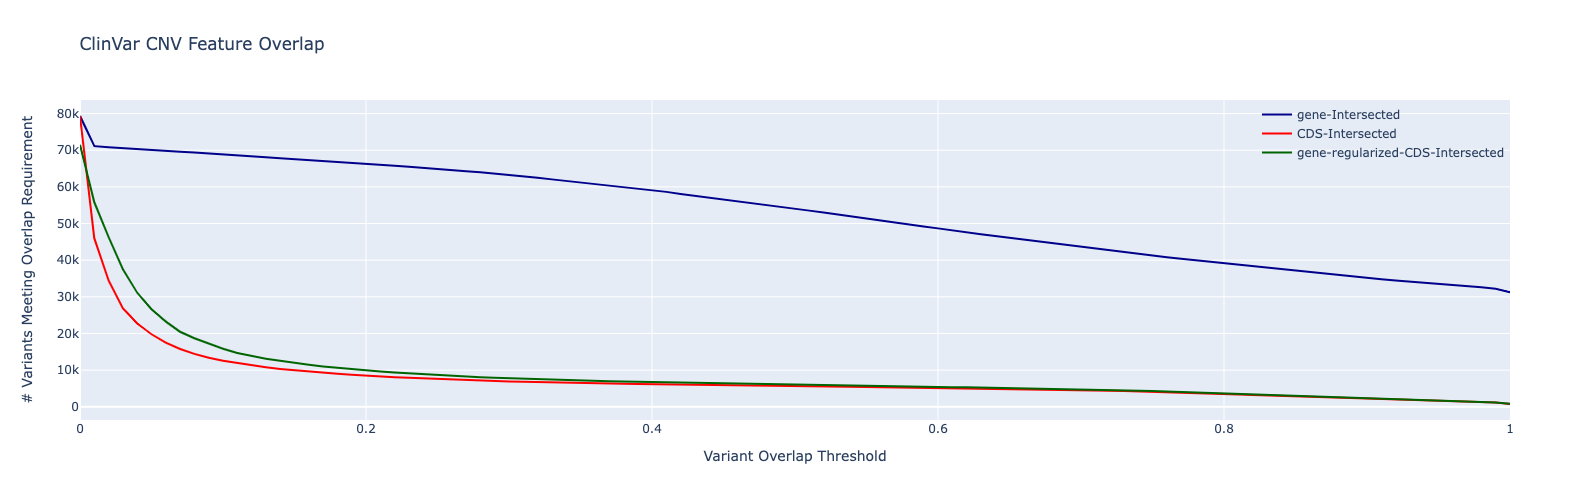

In [46]:
fig = go.Figure()

thrs = list(np.arange(0, 1.01, 0.01))
values_dict = {"gene": [], "CDS": []}
for feature, color in zip(["gene", "CDS"], ["DarkBlue", "Red"]):
    for thr in thrs:
        values_dict[feature].append(len(dv[dv[f"{feature}_overlap"] >= thr]))
    fig.add_trace(
        go.Scatter(
            x=thrs,
            y=values_dict[feature],
            name=f"{feature}-Intersected",
            marker_color=color,
        )
    )

values = []
for thr in thrs:
    values.append(len(dv[dv["CDS_overlap_of_gene"] >= thr]))
fig.add_trace(
    go.Scatter(
        x=thrs,
        y=values,
        name="gene-regularized-CDS-Intersected",
        marker_color="DarkGreen",
    )
)
fig.update_xaxes(title="Variant Overlap Threshold", range=[0, 1])
fig.update_yaxes(
    title="# Variants Meeting Overlap Requirement",
)
fig.update_layout(
    title="ClinVar CNV Feature Overlap",
    height=500,
    width=750,
    legend=dict(x=1, xanchor="right", bgcolor="rgba(0,0,0,0)"),
)
fig.show()

# Match NCH variants to ClinVar

## Calculation of Jaccard similarity measures
* Let $Q$ deote the set of base pairs covered by a given NCH query variant $q$
* Let $S$ denote the set of base pairs between the start and stop positions of a given variant $s$ in the ClinVar search space. 
* Let $\text{Gene}$ and $\text{Coding}$ denote the set of base pairs belonging to any gene or any coding exon, respectively.

Unrestricted Jaccard similarity using base pair overlap between the ranges covered by the query and search variants:
$$\text{Jaccard}(q,s) = \frac{|Q\cap S|}{|Q\cup S|}$$

Gene-restricted Jaccard similarity measure of the commonality between the gene-overlapping parts of the query and search variants:
$$\text{Jaccard}_\text{Gene}(q,s) = \frac{|Q\cap S \cap \text{Gene}|}{|(Q \cup S)\cap \text{Gene}|}$$

Coding-restricted Jaccard similarity measure of the commonality between the coding exon-overlapping parts of the query and search variants:
$$\text{Jaccard}_\text{Coding}(q,s) = \frac{|Q\cap S \cap \text{Coding}|}{|(Q \cup S)\cap \text{Coding}|}$$

### A visual aid for Jaccard similarity

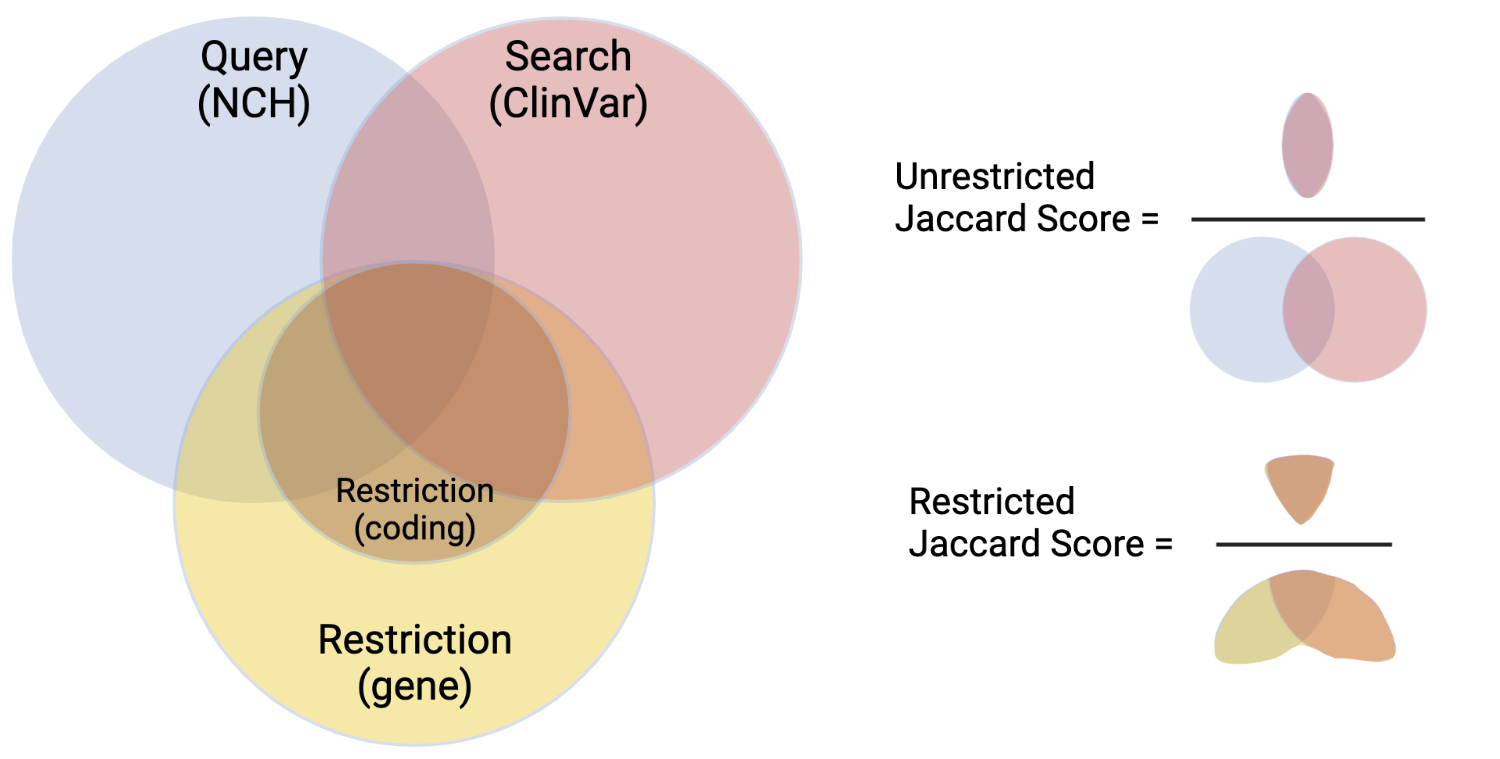

In [47]:
Image("CNV Matching jaccard.png")

In [48]:
### run basic location matching on CNVs
### runs in approximately ~1min
match_dfs = []

clinvar_cols = dv.columns

nch_ix_to_match_df = dict()
for chrom in tqdm(sorted(df["chromosome"].unique())):
    dv_ = dv[dv["chr"] == chrom].copy()
    df_ = df[df["chromosome"] == chrom].copy()
    for ix, row in df_.iterrows():
        ## define the set of candidate match variants
        a, b = row["start_38"], row["stop_38"]
        dv_match = dv_[((a <= dv_["stop_38"]) & (b >= dv_["start_38"]))].copy()

        ## copy all query variant information to match dataframe
        for key in row.keys():
            if not (
                key.startswith("gene_intersection_ranges")
                or key.startswith("CDS_intersection_ranges")
            ):
                dv_match[f"query_{key}"] = row[key]
            elif key.startswith("gene_intersection_ranges") or key.startswith(
                "CDS_intersection_ranges"
            ):
                ranges = (
                    get_string_from_ranges(row[key])
                    if isinstance(row[key], list)
                    else ""
                )
                ranges_list = get_ranges_from_string(ranges)
                dv_match[f"query_{key}"] = ranges
                dv_match[f"query_{key}"] = dv_match[f"query_{key}"].map(
                    {ranges: ranges_list}
                )

        dv_match = dv_match.rename(
            columns={c: f"match_{c}" for c in dv_match if not c.startswith("query")}
        )
        match_dfs.append(dv_match)

dm = pd.concat(match_dfs)

  0%|          | 0/24 [00:00<?, ?it/s]

In [49]:
dm["bp_intersect"] = (
    dm[["query_stop_38", "match_stop_38"]].min(axis=1, skipna=False)
    - dm[["query_start_38", "match_start_38"]].max(axis=1, skipna=False)
    + 1
)
dm["bp_union"] = (
    dm[["query_stop_38", "match_stop_38"]].max(axis=1, skipna=False)
    - dm[["query_start_38", "match_start_38"]].min(axis=1, skipna=False)
    + 1
)
dm["bp_jaccard"] = dm["bp_intersect"] / dm["bp_union"]

### Copy number agreement criteria
So far, we've measured whether CNVs agree solely on the basis of whether they have any base pairs in common; here we also spell out criteria (of increasing strictness) to decide whether they represent the same change in copy number
* <i> Ignore copy number </i> -- only rely on location overlap
* <i> No copy number disagreement </i> -- as long as the copy number information about two variants is not incompatible (and they have location overlap) they can count as a match. Examples:
  * $\text{CNV}_1$ has copy number 3 and $\text{CNV}_2$ has copy number range 3-4; these are not incompatible, so we allow the match
  * $\text{CNV}_1$ has copy number 3 and $\text{CNV}_2$ has no copy number specified (it is a copy number change variant rather than a copy number count); since not enough information is known to deem these incompatible with each other, we allow the match
* <i> Copy number agreement </i> -- we require that copy number agrees between the two variants. Examples:
  * $\text{CNV}_1$ has copy number 3 and $\text{CNV}_2$ has copy number range 3-4; we allow the match
  * $\text{CNV}_1$ has copy number 3 and $\text{CNV}_2$ has no copy number specified; due to missing information, we do not allow the match

In [50]:
dm["copy_number_agree"] = (
    dm["match_absolute_copies"] >= dm["query_copy_number_min"]
) & (dm["match_absolute_copies"] <= dm["query_copy_number_max"])
dm["copy_number_no_disagree"] = ~(
    dm["match_absolute_copies"] < dm["query_copy_number_min"]
) & ~(dm["match_absolute_copies"] > dm["query_copy_number_max"])
dm["copy_number_disagree"] = (
    dm["match_absolute_copies"] < dm["query_copy_number_min"]
) | (dm["match_absolute_copies"] > dm["query_copy_number_max"])

In [51]:
# sanity check: the difference between "no disagreement" and "agreement" is that we allow missing values of copy number to be included in "no disagreement matches"
len(dm[(dm["copy_number_no_disagree"]) & (dm["match_absolute_copies"].notna())]) == len(
    dm[dm["copy_number_agree"]]
)

True

# Calculate gene- and CDS-restricted similarity

In [52]:
### calculate gene and coding sequence feature overlap match scores between NCH and ClinVar variants
### runs in ~1.5 hrs

tqdm.pandas()

for feature in ["gene", "CDS"]:
    dm[f"bp_intersect_{feature}"] = (
        dm[
            [
                f"query_{feature}_intersection_ranges",
                f"match_{feature}_intersection_ranges",
            ]
        ]
        .fillna({np.nan: []})
        .progress_apply(lambda xx: feature_overlap_intersection(xx[0], xx[1]), axis=1)
    )

    dm[f"bp_intersect_{feature}_measure"] = dm[f"bp_intersect_{feature}"].apply(
        get_sizes_of_ranges
    )
    dm[f"bp_query_{feature}_measure"] = dm[
        f"query_{feature}_intersection_ranges"
    ].apply(get_sizes_of_ranges)
    dm[f"bp_match_{feature}_measure"] = dm[
        f"match_{feature}_intersection_ranges"
    ].apply(get_sizes_of_ranges)
    dm[f"bp_union_{feature}_measure"] = (
        dm[f"bp_query_{feature}_measure"]
        + dm[f"bp_match_{feature}_measure"]
        - dm[f"bp_intersect_{feature}_measure"]
    )  # calculate union by adding the individual sizes of each set (which double counts the intersection) then subtract the size of the intersection
    dm[f"bp_jaccard_{feature}"] = (
        dm[f"bp_intersect_{feature}_measure"] / dm[f"bp_union_{feature}_measure"]
    )

  0%|          | 0/1423554 [00:00<?, ?it/s]

  0%|          | 0/1423554 [00:00<?, ?it/s]

In [54]:
dm[
    [
        "query_variant",
        "match_id",
        "match_name",
        "query_build",
        "match_assembly",
        "bp_jaccard",
        "bp_jaccard_gene",
        "bp_jaccard_CDS",
        "copy_number_agree",
        "copy_number_no_disagree",
    ]
].to_csv(
    os.path.join("cnv_data", "match-scoring-results.csv.gz"),
    compression="gzip",
    index=False,
)

In [56]:
with gzip.open(os.path.join("cnv_data", "match-scoring-results.csv.gz"), "rb") as f:
    dm = pd.read_csv(f)

## Visualizing matching criteria with varying match score threshold

In [59]:
def jaccard_matching_figure(
    match_data: pd.core.frame.DataFrame,
    title="Matching with Varying Similarity Threshold",
    subtitle=None,
    step=0.01,
):
    thrs = list(np.arange(0, 1 + step, step))

    fig = go.Figure()

    measures = [c for c in match_data.columns if "jaccard" in c]
    colors = ["DarkBlue", "Goldenrod", "Red"]
    for measure, color in zip(measures, colors):
        values1 = []
        values2 = []
        values3 = []
        for thr in tqdm(thrs):
            dm_ = match_data[match_data[measure] >= thr].copy()
            values1.append(dm_["query_variant"].nunique())
            values2.append(
                dm_[dm_["copy_number_no_disagree"]]["query_variant"].nunique()
            )
            values3.append(dm_[dm_["copy_number_agree"]]["query_variant"].nunique())

        name_pfx = f"{measure.split('_')[-1].title()}".replace(
            "Jaccard", "Base Pair Range"
        )
        fig.add_trace(
            go.Scatter(
                x=thrs,
                y=values1,
                marker_color=color,
                line_dash="dot",
                name=f"{name_pfx} - CN Ignored",
                legendgroup="ignore",
            )
        )
        fig.add_trace(
            go.Scatter(
                x=thrs,
                y=values2,
                marker_color=color,
                line_dash="dash",
                name=f"{name_pfx} - No CN Disagreement",
                legendgroup="lax",
            )
        )
        fig.add_trace(
            go.Scatter(
                x=thrs,
                y=values3,
                marker_color=color,
                line_dash="solid",
                name=f"{name_pfx} - CN Agreement",
                legendgroup="strict",
            )
        )

    fig.update_xaxes(
        title="Jaccard Similarity Threshold", linecolor="black", title_font_size=20
    )
    fig.update_yaxes(
        title="# Variants with ≥1 Match", linecolor="black", title_font_size=20
    )
    if subtitle:
        title = f"{title}<br>{subtitle}"
    fig.update_layout(
        title=title,
        title_font_size=24,
        title_x=0.5,
        height=750,
        width=1000,
        plot_bgcolor="white",
        legend_bgcolor="rgba(0,0,0,0)",
        legend=dict(x=1, xanchor="right"),
    )

    for tr in fig.data:
        name = tr.name
        if "Cds" in name:
            fig.update_traces(
                selector=dict(name=name), name=name.replace("Cds", "Coding Exon")
            )

    return fig

## Matching to full search space

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

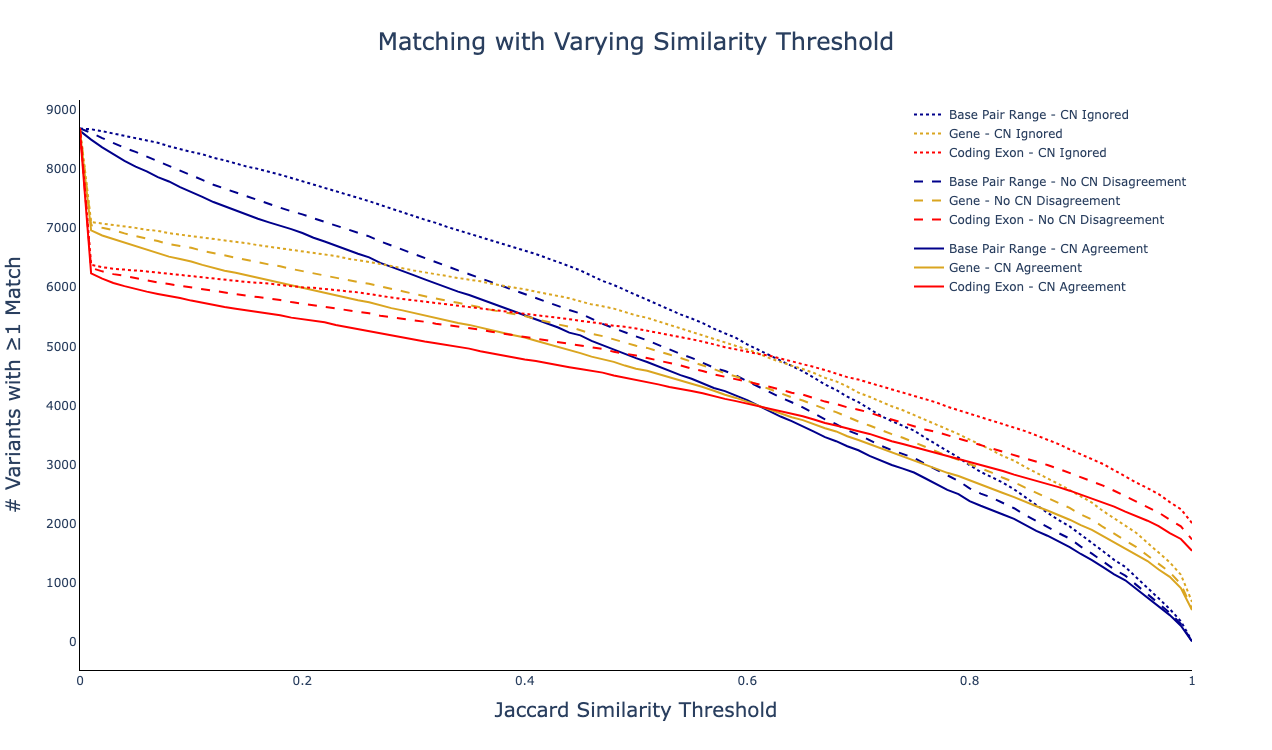

In [60]:
fig = jaccard_matching_figure(dm)
fig.show()

### Figure: Jaccard similarity matching between NCH and ClinVar Variants with varying match score threshold
The horizontal axis represents minimum allowed Jaccard score required for a match; the vertical axis then measures the number of query variants (NCH variants) which have a match under the corresponding matching policy. The different texture of lines correspond to different copy number matching policies ("ignore copy number", "no copy number disagreement", and "copy number agreement").

The different color traces represent overlap restricted to different genomic features.
* Blue: base pair/location overlap (the most elementary, merely relies on the start and stop positions of the query variant and candidate match variant)
* Yellow: gene overlap
* Red: coding sequence overlap

Points near the far left represent matching policies that are very lax; variants are considered a match as long as they have nonzero overlap on the given feature. The right end, requiring Jaccard score of 1, is the strictest possible, meaning that the variants must span the exact same base pair range (or overlap with exactly the same locations on genes or in coding sequences)

### Extract just the base pair and coding sequence overlap traces from the matching figure

In [61]:
fig_bp_coding = go.Figure(layout=fig.layout)
for tr in fig.data:
    if "gene" in tr.name.lower():
        continue
    else:
        fig_bp_coding.add_trace(tr)

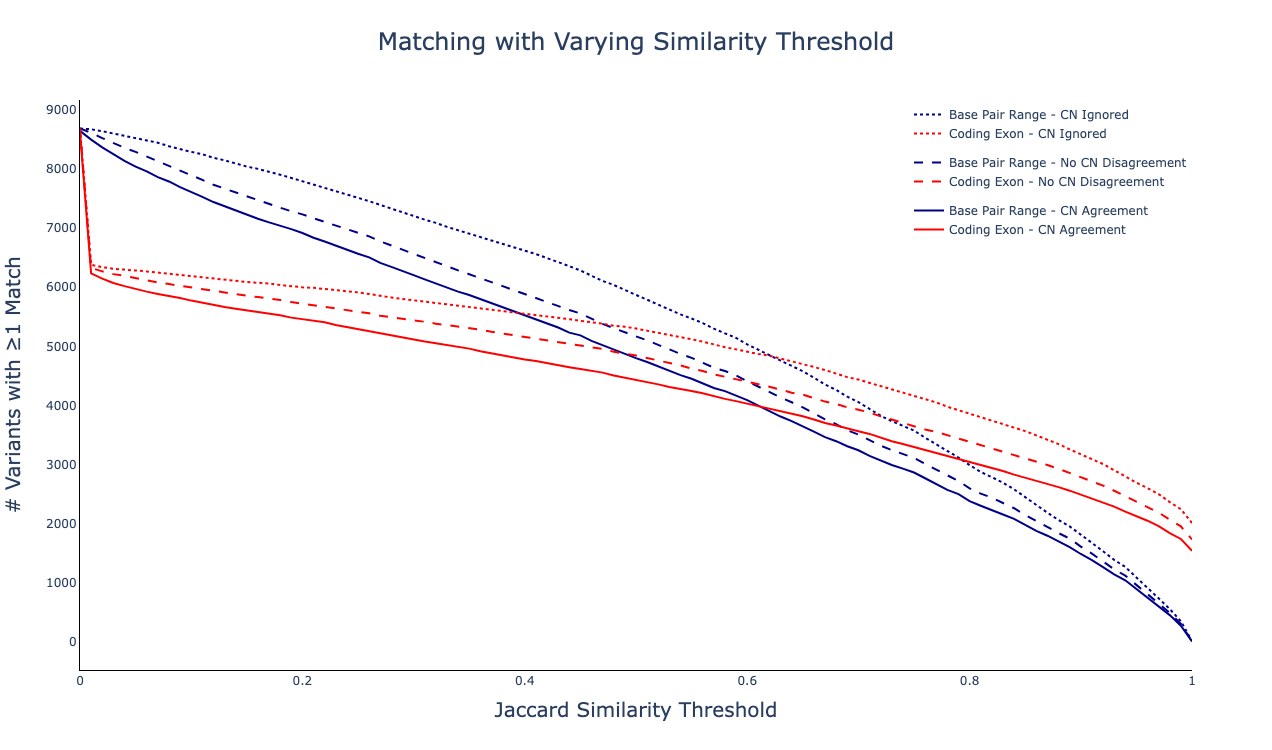

In [62]:
fig_bp_coding